In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from pathlib import Path
import dask.dataframe as dd

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Purpose
The purpose of this notebook is to compute thresholds for a bankruptcy dummy baseline. We do this by computing some financial ratios and fitting an ROC model to the data, thus determining what thresholds for the financial rations should be used to predict bankruptcy (1) or no bankruptcy (0).

## User dependent paths

In [2]:
# path depending on user
if Path.home().name == "nikolaibeckjensen":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"
elif Path.home().name == "annabramslow":
    DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet(2)" / "Virk2Vec" / "data"
elif Path.home().name == "147319":
    DATA_ROOT = Path.home() / "master_thesis" / "data"
elif Path.home().name == "146512":
    DATA_ROOT = Path.home() / "master_thesis" / "data"
else: 
    DATA_ROOT = Path.home() / "data"

## Data loading

Fetching training data (CVRs from training split) as well as raw annual report data

In [3]:
#load training data for bankruptcy prediction population
df_population = pd.read_pickle(DATA_ROOT / "processed" / "populations" / "dummy_predictions" / "intermediate" /"df_bankruptcy_train.pkl")

In [8]:
annual_report_directory = DATA_ROOT/'processed'/'sources'/'financials'/'tokenized'
annualreport_csv = [file for file in annual_report_directory.iterdir() if file.is_file() and file.suffix == '.parquet']
df_annualreport = dd.read_parquet(annualreport_csv).compute()
#turn cvr index to column
df_annualreport['CVR'] = df_annualreport.index
df_annualreport.reset_index(drop=True, inplace=True)

In [9]:
# find latest financial data for each company
df_financials = df_annualreport.sort_values(by=['CVR', 'FROM_DATE'])
df_financials = df_financials.drop_duplicates(subset=['CVR'], keep = 'last')

## Computing ratios

We compute two financial ratios inspired by Altman's Z-score methodology.

$$
\frac{\text{Working capital}}{\text{Total assets}}
$$

where 

$$
\text{Working capital} = \text{Current Assets} - \text{Current Liabilities}
$$

We define Current Liabilities as Short Term Liabilities.

In addition, we adapt

$$
\frac{\text{EBIT}}{\text{Total assets}}
$$

where EBIT is Earnings before interest and taxes, to 

$$
\frac{\text{ProfitLoss}}{\text{Total assets}}
$$


In [11]:
df = df_population.merge(df_financials, on='CVR', how='left')

In [13]:
df["WorkingCapital"] = df["CURRENT_ASSETS"] - df["SHORT_TERM_LIABILITIES"]
df["WorkingAssetRatio"] = df["WorkingCapital"] / df["ASSETS"]
df["ProfitAssetRatio"] = df["PROFIT_LOSS"] / df["ASSETS"]

In [14]:
#manual fix for division by zero
df.loc[df.ASSETS == 0, "WorkingAssetRatio"] = 0
df.loc[df.ASSETS == 0, "ProfitAssetRatio"] = 0

#manual fix for nan values
df = df.fillna(0)

In [15]:
df_target = df[['CVR', 'TARGET','WorkingAssetRatio', 'ProfitAssetRatio']]

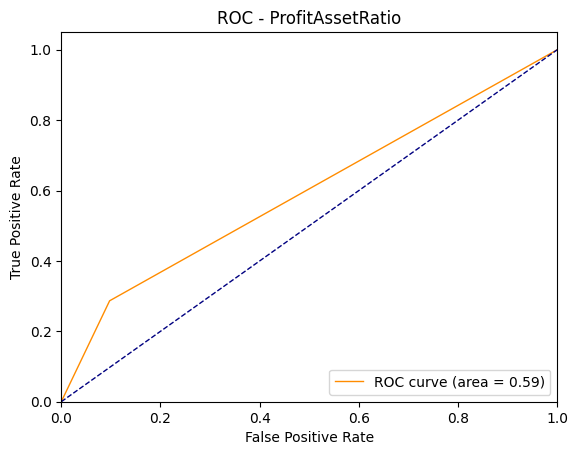

In [18]:
# fit ROC curve for bankruptcy prediction
X = df_target[['ProfitAssetRatio']]
y = df_target['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - ProfitAssetRatio')
plt.legend(loc="lower right")
plt.show()

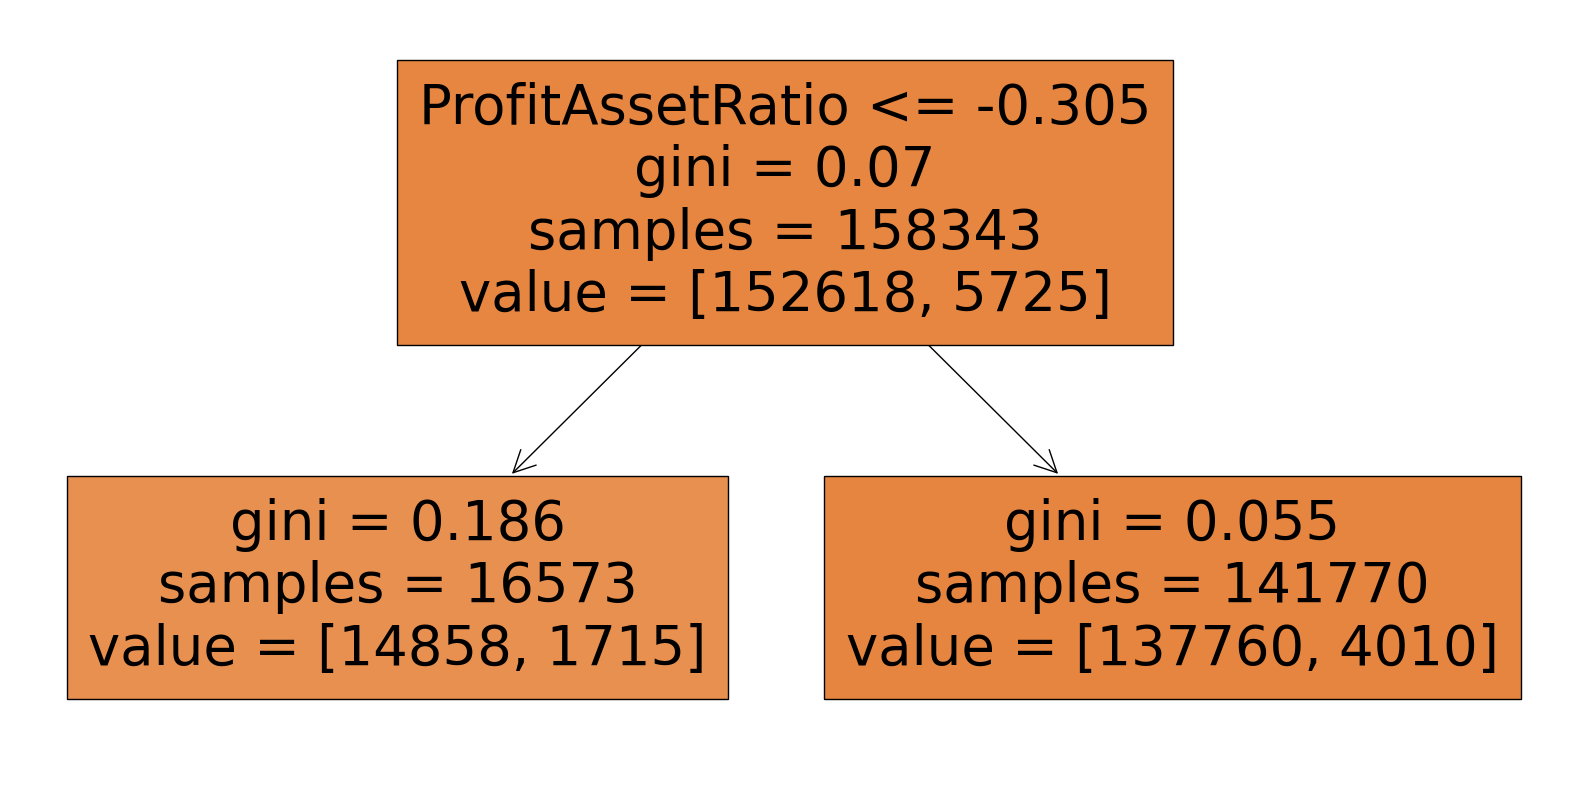

In [19]:
#find decition tree decision boundary
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()

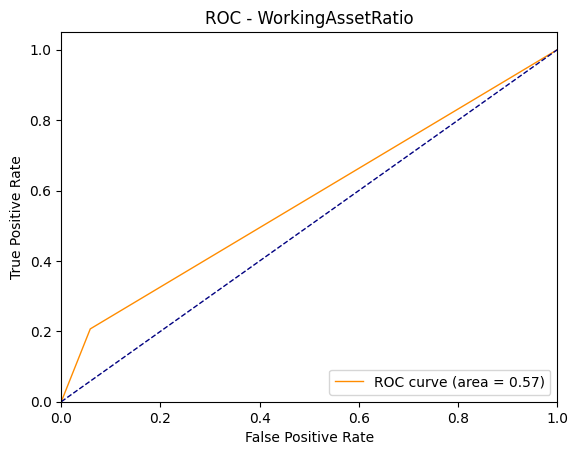

In [20]:
# fit ROC curve for bankruptcy prediction
X = df_target[['WorkingAssetRatio']]
y = df_target['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = DecisionTreeClassifier(random_state=42,max_depth=1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - WorkingAssetRatio')
plt.legend(loc="lower right")
plt.show()

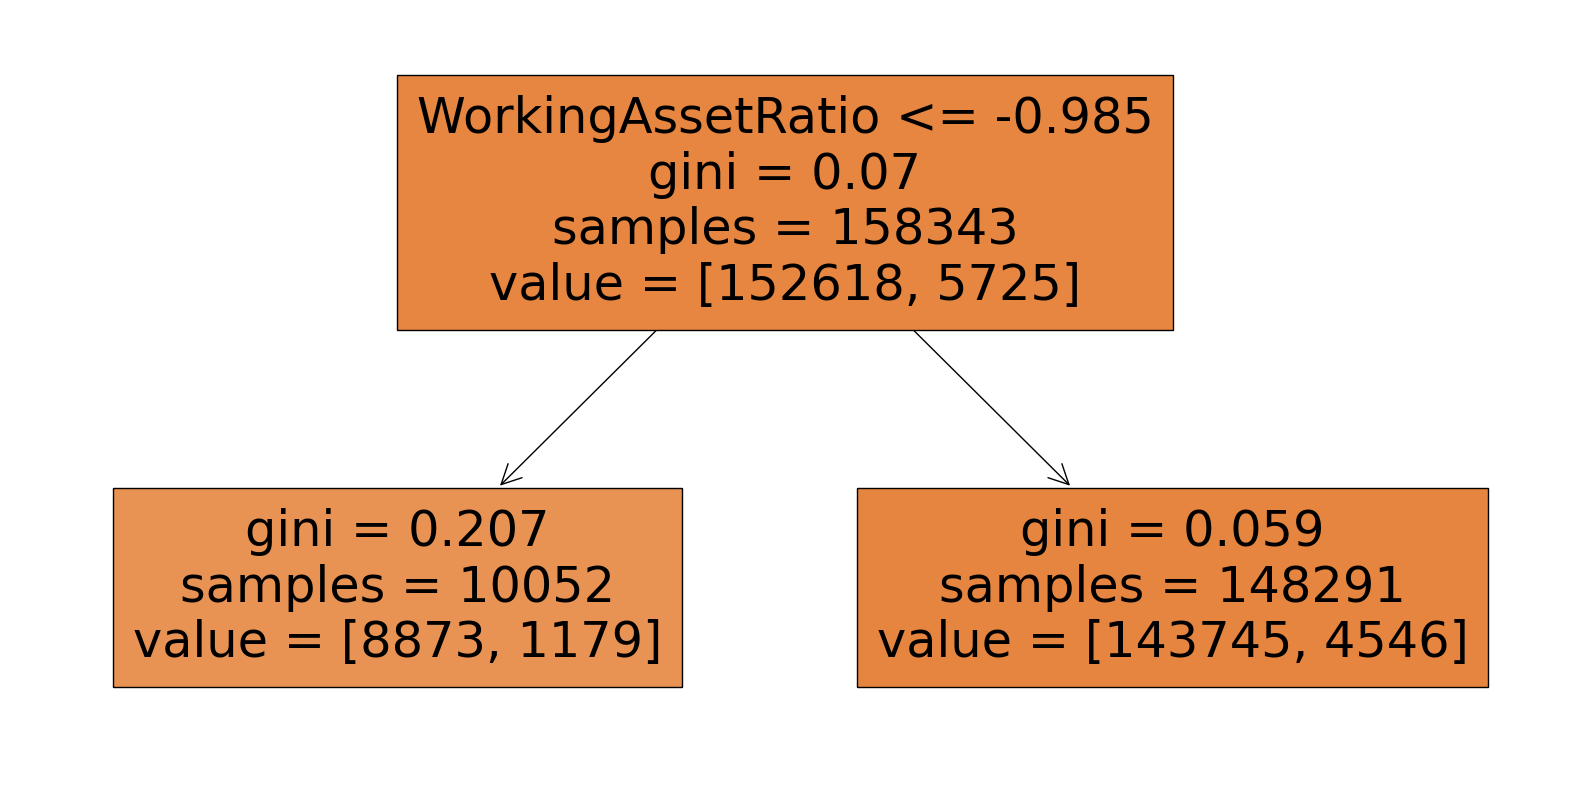

In [21]:
#find decition tree decision boundary
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()

We use threshold WorkingAssetRatio <= -0.985 to determine bankruptcies in our test set.